# House Price Prediction Project Intro

In this project I'll do EDA and Price Prediction of houses using real-world data. I'll get this data from biggest real estate marketplace in my country-[Bina.az](https://bina.az/). I'll do some Web Scraping, then EDA and Data Cleaning, Preprocessing. Finally, several ML models will be tested and the best one will be tuned. At the end, I'll deploy the model as a Web Service.

In [2]:
import numpy as np
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import joblib
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# Gathering Data

As I mentioned prevoiusly, instead of synthetic ready-to-use datasets, I want to use real-world data. Hence, I have to collect it myself. I've decided to use `BeautifulSoup` library, as it's easy-to-use tool (compared to Selenium) that meets all my needs.

In [5]:
url='https://bina.az/items/all'
page=requests.get(url)

In [6]:
parsed_page=BeautifulSoup(page.content, 'html.parser')

In [7]:
home_info=parsed_page.find_all('div', class_='card_params')
home_info[:3]

[<div class="card_params"><div class="abs_block"><div class="price"><span class="price-val">203 000</span><span class="price-cur">AZN</span></div></div><div class="location">Əhmədli q.</div><ul class="name"><li>3 otaqlı</li><li>127 m²</li><li>7/20 mərtəbə</li></ul><div class="card_footer"><div class="city_when">Bakı, bugün 14:10</div></div></div>,
 <div class="card_params"><div class="abs_block"><div class="price"><span class="price-val">900</span><span class="price-cur">AZN</span><span class="price-per">/ay</span></div></div><div class="location">Binəqədi r.</div><ul class="name"><li>5 otaqlı</li><li>160 m²</li><li>2/16 mərtəbə</li></ul><div class="card_footer"><div class="city_when">Bakı, bugün 14:10</div></div></div>,
 <div class="card_params"><div class="abs_block"><div class="price"><span class="price-val">106 000</span><span class="price-cur">AZN</span></div></div><div class="location">Nərimanov r.</div><ul class="name"><li>3 otaqlı</li><li>55 m²</li><li>9/9 mərtəbə</li></ul><div

Well, it looks very messy, but it's just an HTML. Let's prettify a single example, so it's easier to read.

In [8]:
print(home_info[0].prettify())

<div class="card_params">
 <div class="abs_block">
  <div class="price">
   <span class="price-val">
    203 000
   </span>
   <span class="price-cur">
    AZN
   </span>
  </div>
 </div>
 <div class="location">
  Əhmədli q.
 </div>
 <ul class="name">
  <li>
   3 otaqlı
  </li>
  <li>
   127 m²
  </li>
  <li>
   7/20 mərtəbə
  </li>
 </ul>
 <div class="card_footer">
  <div class="city_when">
   Bakı, bugün 14:10
  </div>
 </div>
</div>


Much better! From here it's easy to see all information required: square meters, city, rooms, floor and price. What we need is to get rid of all HTML tags, extract all these values and put them into a table. Let's write a function for HTML cleaning.

In [9]:
def extract_from_tag(tag, house_type=None):
    house_dict={'Price': None,
                'Offer Type': None,
                'Location': None,
                'Rooms': None,
                'Meters^2': None,
                'Floor': None,
                'House Type': house_type}
    house_dict['Price']=float(tag.find('span', class_="price-val").contents[0].replace(' ', ''))
    offer_type=tag.find('span', class_="price-per")
    if offer_type:
        if 'ay' in offer_type.contents[0]:
            house_dict['Offer Type']='Monthly Rent'
        elif 'gün' in offer_type.contents[0]:
            house_dict['Offer Type']='Daily Rent'
    else:
        house_dict['Offer Type']='For Sale'
    house_dict['Location']=tag.find('div', class_="location").contents[0]
    overall_info=tag.find('ul', class_="name")
    room=overall_info.findAll(text=re.compile('otaqlı'))
    meter=overall_info.findAll(text=re.compile('m²'))
    floor=overall_info.findAll(text=re.compile('mərtəbə'))
    if room:
        house_dict['Rooms']=int(re.findall("\d+", room[0])[0])
    if meter:
        house_dict['Meters^2']=int(re.findall("\d+", meter[0])[0])
    if floor:
        house_dict['Floor']=int(re.findall("\d+", floor[0])[0])
    return house_dict

for h in home_info:
    print(extract_from_tag(h))

{'Price': 203000.0, 'Offer Type': 'For Sale', 'Location': 'Əhmədli q.', 'Rooms': 3, 'Meters^2': 127, 'Floor': 7, 'House Type': None}
{'Price': 900.0, 'Offer Type': 'Monthly Rent', 'Location': 'Binəqədi r.', 'Rooms': 5, 'Meters^2': 160, 'Floor': 2, 'House Type': None}
{'Price': 106000.0, 'Offer Type': 'For Sale', 'Location': 'Nərimanov r.', 'Rooms': 3, 'Meters^2': 55, 'Floor': 9, 'House Type': None}
{'Price': 129999.0, 'Offer Type': 'For Sale', 'Location': 'Binəqədi r.', 'Rooms': 4, 'Meters^2': 110, 'Floor': 9, 'House Type': None}
{'Price': 174000.0, 'Offer Type': 'For Sale', 'Location': 'Elmlər Akademiyası m.', 'Rooms': 3, 'Meters^2': 80, 'Floor': 2, 'House Type': None}
{'Price': 105000.0, 'Offer Type': 'For Sale', 'Location': 'Badamdar q.', 'Rooms': 4, 'Meters^2': 100, 'Floor': None, 'House Type': None}
{'Price': 169000.0, 'Offer Type': 'For Sale', 'Location': 'İçəri Şəhər m.', 'Rooms': 2, 'Meters^2': 60, 'Floor': 3, 'House Type': None}
{'Price': 87000.0, 'Offer Type': 'For Sale', 'Lo

Great! But it's only a first page of the site. We need to collect all information from all pages. Let's write a function for that too.

In [10]:
def get_all_info(page_url, house_type):
    house_list, page_count=[], 1
    is_stop=False
    while not is_stop:
        current_url=page_url+f'?page={page_count}'
        current_page=requests.get(current_url)
        current_parsed_page=BeautifulSoup(current_page.content, 'html.parser')
        current_home_info=current_parsed_page.find_all('div', class_='card_params')
        if len(current_home_info)==0:
            print(f'{house_type}\nLast Page: {page_count}\n# of houses: {len(house_list)}\n')
            is_stop=True
        for h in current_home_info:
            house_list.append(extract_from_tag(h, house_type=house_type))
        page_count+=1
    
    return house_list

Now I'll take all houses from each category (I'll translate category names later) and then put it into a single DataFrame.

In [11]:
base_url='https://bina.az/alqi-satqi/menziller'
urls=['/kohne-tikili', '/yeni-tikili']

all_houses=[]
for u in urls:
    all_houses.append(get_all_info(base_url+u, house_type=u.split('/')[-1]))

KeyboardInterrupt: 

In [ ]:
full_df=pd.DataFrame()

for data in all_houses:
    full_df=pd.concat([full_df, pd.DataFrame.from_records(data)])
    print(full_df.shape)

(9501, 7)
(42990, 7)


# Data Preparation

Finally there is a dataset that one can work with. It's still "raw" (requires cleaning). Firstly there are lots of duplicates in it because:
* People can place the same house ad many times
* There are VIP ads that are pinned to the page (the same among all pages)

So let's remove them all and save the daatset in `.csv` format.

## Dropping Duplicates

In [ ]:
full_df.head()

,Price,Offer Type,Location,Rooms,Meters^2,Floor,House Type
0,162000.0,For Sale,İnşaatçılar m.,3,95,3.0,kohne-tikili
1,87000.0,For Sale,3-cü mikrorayon q.,2,50,2.0,kohne-tikili
2,86000.0,For Sale,Biləcəri q.,3,76,8.0,kohne-tikili
3,198000.0,For Sale,Nərimanov r.,4,120,3.0,kohne-tikili
4,77000.0,For Sale,Memar Əcəmi m.,2,45,1.0,kohne-tikili


In [ ]:
full_df.drop_duplicates(inplace=True)
full_df.shape

(28574, 7)

In [ ]:
full_df.to_csv('../data/houses.csv', index=False)

In [3]:
full_df=pd.read_csv('../data/houses.csv')

And let's properly name categories.

In [4]:
full_df['House Type'].replace({
                        'yeni-tikili': 'new-build',
                        'kohne-tikili': 'old-build'}, inplace=True)

Now it's time to explore a bit, look at dimensions, datatypes, missing values, etc.

In [5]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28574 entries, 0 to 28573
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Price       28574 non-null  float64
 1   Offer Type  28574 non-null  object 
 2   Location    28574 non-null  object 
 3   Rooms       28574 non-null  int64  
 4   Meters^2    28574 non-null  int64  
 5   Floor       28440 non-null  float64
 6   House Type  28574 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 1.5+ MB


## Filling Nulls

There is only oen column with nulls-`Floor`. I'll just use median imputation. Also I'll drop `Offer Type`, as it's now useless (I'm using only houses for sale, not rent).

In [6]:
median_floor=int(full_df['Floor'].median())
full_df['Floor'].fillna(median_floor, inplace=True)
full_df.drop('Offer Type', axis=1, inplace=True)

In [7]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28574 entries, 0 to 28573
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Price       28574 non-null  float64
 1   Location    28574 non-null  object 
 2   Rooms       28574 non-null  int64  
 3   Meters^2    28574 non-null  int64  
 4   Floor       28574 non-null  float64
 5   House Type  28574 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 1.3+ MB


## Dealing with Outliers

In [8]:
full_df.describe()

,Price,Rooms,Meters^2,Floor
count,2.857400e+04,28574.000000,28574.000000,28574.000000
mean,2.009358e+05,2.838700,116.428151,7.942745
std,1.807372e+05,0.972437,1044.960582,4.983760
min,3.600000e+01,1.000000,6.000000,1.000000
25%,1.100000e+05,2.000000,68.000000,4.000000
50%,1.550000e+05,3.000000,95.000000,7.000000
75%,2.374300e+05,3.000000,134.000000,12.000000
max,5.000000e+06,20.000000,150000.000000,27.000000


In [9]:
def find_outliers(data, column, coef):
    q1, q3=data[column].describe()[['25%', '75%']]
    iqr=q3-q1
    outliers_low=list(data[data[column]<(q1-coef*iqr)].index)
    outliers_up=list(data[data[column]>(q3+coef*iqr)].index)
    outliers=outliers_low+outliers_up
    print(f'{column}: There are {len(outliers)} ({len(outliers)/data.shape[0]*100:.2f}%) outliers out of {data.shape[0]} rows')
    return set(outliers)


all_out_idx=[]
for c in full_df.select_dtypes(include=['int64', 'float64']).columns:
    all_out_idx.extend(find_outliers(full_df, c, 1.5))

all_out_ind=set(all_out_idx)
print(f'There are total {len(all_out_ind)} ({len(all_out_ind)/full_df.shape[0]*100:.2f}%) rows with at least one outlier value\n')
full_df.drop(all_out_ind, inplace=True)

Price: There are 1639 (5.74%) outliers out of 28574 rows
Rooms: There are 1126 (3.94%) outliers out of 28574 rows
Meters^2: There are 804 (2.81%) outliers out of 28574 rows
Floor: There are 44 (0.15%) outliers out of 28574 rows
There are total 2377 (8.32%) rows with at least one outlier value



As the share of outliers is not that big, they can be just dropped. Dropping outliers is not always a good idea, as you delete the data entirely. You should investigatre and maybe use something else (e.g., transformation, capping).

In [20]:
full_df.shape

(26157, 6)

# Exploratory Data Analysis

Now it's time to do some EDA to explore and analyze dataset using various data visualizations.

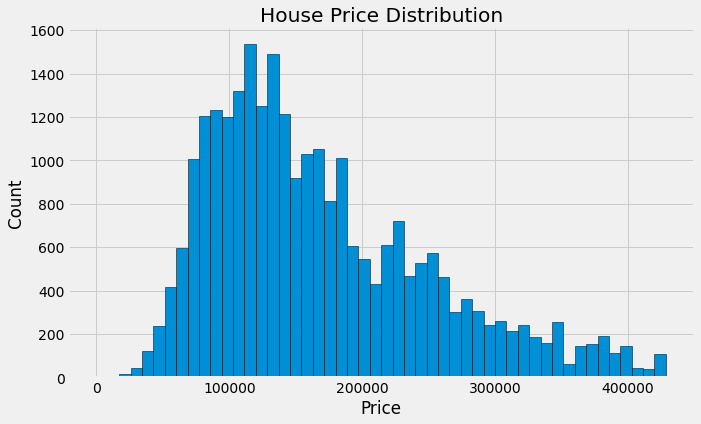

In [21]:
plt.figure(figsize=(10,6))
plt.hist(full_df['Price'], bins=50, edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('House Price Distribution');

Even after outlier removal from Price column, it's still quite right skewed (which is common for price/income columns actually). Here log transform could help to deskew it.

Now let's look at correlation values between target and features.

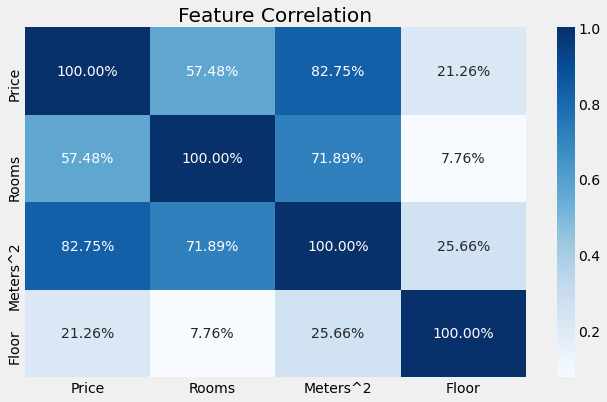

In [22]:
plt.figure(figsize=(10,6))
sns.heatmap(full_df.corr(), annot=True, fmt='.2%', cmap='Blues')
plt.title(f'Feature Correlation');

No surprises here. Price is highly correlated with Square Meters and # of Rooms. Floor nunber has weaker correlation.

As for `House Type`, it's a categorical variable, so it's relationship with `Price` can be explored using boxplot.

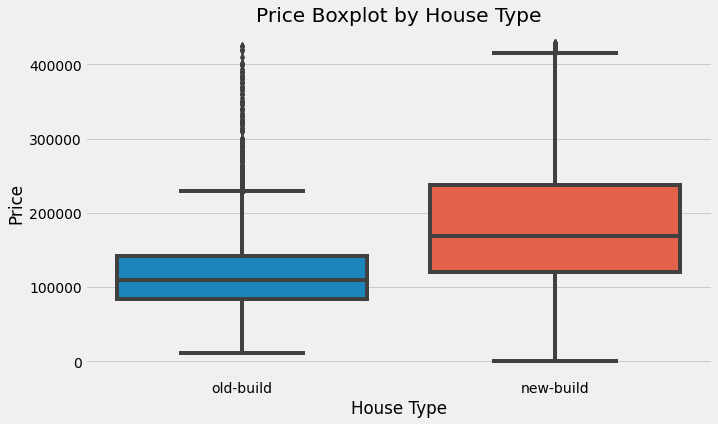

In [23]:
def get_boxplots_price(x):
    plt.figure(figsize=(10,6))
    sns.boxplot(data=full_df, y='Price', x=x)
    plt.title(f'Price Boxplot by {x}')

get_boxplots_price('House Type')

Actually, it's also possible to use boxplots for `Price` and `Rooms` too (as `Rooms` is a discrete variable with few unique values).

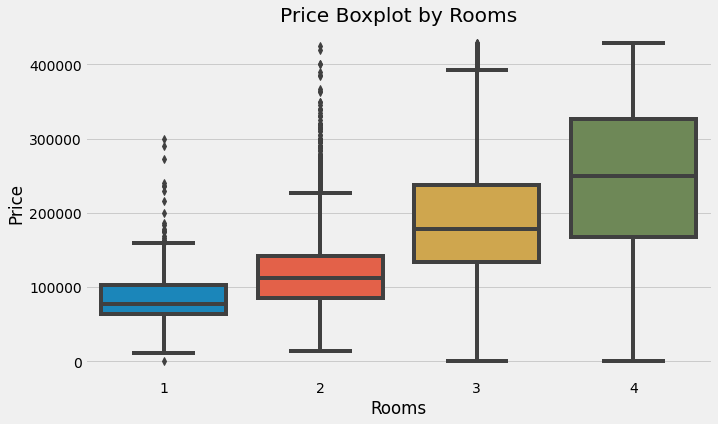

In [24]:
get_boxplots_price('Rooms')

# Feature Engineering

In this section I'll do some transformations on exiting columns and add a couple of new ones. But first, data must be divided into train and test sets to avoid any data leakage while processing data. Later I'll build a pipeline that will take unseen data and transform it (add features, converting old ones, etc).

In [116]:
full_df_train, full_df_test=train_test_split(full_df, test_size=0.2)

Feature called `InCapital` will be added. It's a binary feature that shows whether the house in capital city (hence, probably more expensive) or not. `Location` column can be used for that, as houses in capital has `q.`/`r.` (city's district) or `m.` (near city's subway station) in thier location. Also `Near Subway` can be added using the same logic.

In [117]:
full_df_train['In Capital']=full_df_train['Location'].str.contains('|'.join(['q\.', 'm\.', 'r\.'])).map({True: 'yes', False: 'no'})
full_df_train['Near Subway']=full_df_train['Location'].str.contains(' m\.').map({True: 'yes', False: 'no'})

In [118]:
full_df_train.head()

,Price,Location,Rooms,Meters^2,Floor,House Type,In Capital,Near Subway
3708,132000.0,28 May m.,2,53,4.0,old-build,yes,yes
676,85500.0,Yeni Yasamal q.,3,70,1.0,old-build,yes,no
4538,150000.0,Badamdar q.,4,120,4.0,old-build,yes,no
23182,249900.0,28 May m.,4,144,17.0,new-build,yes,yes
24715,245000.0,Yasamal r.,2,106,14.0,new-build,yes,no


Now let's divide the data into X and y.

In [119]:
X_train, X_test=full_df_train.drop('Price', axis=1), full_df_test.drop('Price', axis=1)
y_train, y_test=full_df_train['Price'], full_df_test['Price']

Here I'll build a data-preprocessing pipeline. There I'll use `PolynomialFeatures` to create lots of new features, `SelectPercentile` for feature selection and also `OneHotEncoder`, `StandardScaler` for categorical and numeric features respectively. Also a function for adding hand-crafted features and preprocessing will be used.

In [120]:
def test_transformer(data, pipe):
    data['In Capital']=data['Location'].str.contains('|'.join(['q\.', 'm\.', 'r\.'])).map({True: 'yes', False: 'no'})
    data['Near Subway']=data['Location'].str.contains(' m\.').map({True: 'yes', False: 'no'})
    data_tr=pipe.transform(data)
    return data_tr

In [121]:
cat_cols=['Location', 'House Type', 'In Capital', 'Near Subway']
num_cols=['Rooms', 'Floor', 'Meters^2']

num_pipe=Pipeline([
    ('polynom', PolynomialFeatures(2)),
    ('feature_select', SelectPercentile(score_func=f_regression, percentile=66)),
    ('std_scaler', StandardScaler())
])

transformer=make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), cat_cols),
    (num_pipe, num_cols)
)

X_train_tr=transformer.fit_transform(X_train,y_train)
X_test_tr=test_transformer(X_test, transformer)

X_train_tr.shape, X_test_tr.shape

((20925, 140), (5232, 140))

It works! Now let's save this pipeline for later use in web app.

In [122]:
joblib.dump(transformer, '../models/test_prep_pipe.bin')

['../models/test_prep_pipe.bin']

Now it's time for testing several ML regression models and select the best one.

# Model Selection

In this section I'll choose the model for orice prediction and later tune its hyperparameters.

In [123]:
def train_and_eval(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    mae=mean_absolute_error(y_test, model.predict(X_test))
    rmse=mean_squared_error(y_test, model.predict(X_test), squared=False)
    return ('MAE', mae), ('RMSE', rmse)

In [124]:
models={'Linear Regression':LinearRegression(),
        'Random Forest':RandomForestRegressor(n_jobs=-1),
        'XGBoost': xgb.XGBRegressor(n_jobs=-1),
        'LightGBM': lgb.LGBMRegressor(n_jobs=-1),
        'KNN':KNeighborsRegressor(n_neighbors=5, n_jobs=-1),
        'SVM': SVR(C=1000, gamma=0.1)}

res=dict()

for model_name, alg in models.items():
        res[model_name]=train_and_eval(X_train_tr, y_train, X_test_tr, y_test, alg)

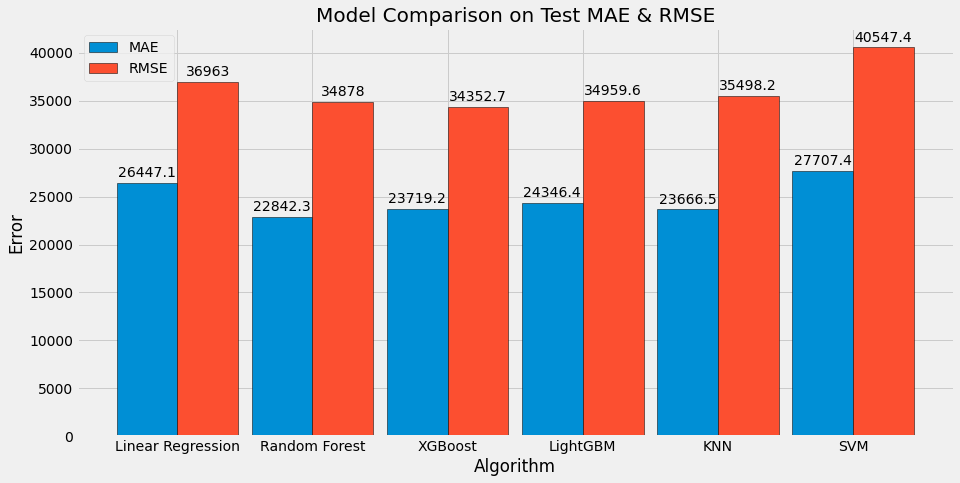

In [125]:
res_df=pd.DataFrame({'Model':list(res.keys()),
                    'MAE': [x[0][1] for x in res.values()],
                    'RMSE': [x[1][1] for x in res.values()]})

fig, ax=plt.subplots(figsize=(14, 7))

x=np.arange(res_df.shape[0]) 
width=0.45
maes=ax.bar(x-width/2, res_df['MAE'], width, label='MAE', edgecolor='k')
rmses=ax.bar(x+width/2, res_df['RMSE'], width, label='RMSE', edgecolor='k')

ax.bar_label(maes, padding=3)
ax.bar_label(rmses, padding=3)

ax.set_ylabel('Error')
ax.set_xlabel('Algorithm')
ax.set_xticks(x, list(res.keys()), size=14)
ax.legend()
ax.set_title('Model Comparison on Test MAE & RMSE', size=20);

XGBoost and Random Forest show the best results. I'll select XGBoost and tune it to get a better performance.

# Model Optimization

This is the last section of the project (and probably the most computationally expensive): hyperparameter tuning. For that, `RandomizedSearchCV` will be used.

In [127]:
params={'max_depth': np.arange(5, 15),
    'learning_rate': np.arange(0.01, 0.3, 0.01),
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'n_estimators': np.arange(100, 1001, 25),
    'gamma': np.arange(0, 1.01, 0.1)
}

xgb_reg=xgb.XGBRegressor()

rand_opt_cv=RandomizedSearchCV(estimator=xgb_reg,                                    
                    param_distributions=params,                      
                    scoring='neg_mean_absolute_error',                                  
                    cv=5,                                           
                    n_iter=120,
                    n_jobs=-1,
                    verbose=2)

In [128]:
rand_opt_cv.fit(X_train_tr, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29]),
                                        'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_estimators': array([ 100,  125,  150,  175,  200,  225,  250,  275,  300,  325,  350,
        375,  400,  425,  450,  475,  500,  525,  550,  575,  600,  625,
        650,  675,  700,  725,  750,  775,  800,  825,  850,  875,  900,
        925,  950,  975, 1000]),
                                        'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])},
                   scoring='neg_mean_absolute_error', verbose=2)

Now let's compare performance of a default XGBoost and a tuned one.

In [129]:
default_xgb=xgb.XGBRegressor()
default_xgb.fit(X_train_tr, y_train)
y_pred_default=default_xgb.predict(X_test_tr)
print(f'Default XGBoost MAE: {mean_absolute_error(y_test, y_pred_default)}')
print(f'Default XGBoost RMSE: {mean_squared_error(y_test, y_pred_default, squared=False)}\n')

y_pred_best=rand_opt_cv.best_estimator_.predict(X_test_tr)
print(f'Tuned XGBoost MAE: {mean_absolute_error(y_test, y_pred_best)}')
print(f'Tuned XGBoost RMSE: {mean_squared_error(y_test, y_pred_best, squared=False)}')

Default XGBoost MAE: 23719.205684556873
Default XGBoost RMSE: 34352.69714053805

Tuned XGBoost MAE: 22159.940140377126
Tuned XGBoost RMSE: 33611.604867733346


There's a clear performance boost here. Now the tuned model must be trained on a whole dataset and saved for later use. Let's look at the parameters first.

In [131]:
best_params=rand_opt_cv.best_params_
best_params

{'subsample': 0.8999999999999999,
 'n_estimators': 925,
 'max_depth': 12,
 'learning_rate': 0.04,
 'gamma': 0.8,
 'colsample_bytree': 0.5,
 'colsample_bylevel': 0.7}

In [132]:
X, y=full_df.drop('Price', axis=1), full_df['Price']
data_transformer=joblib.load('../models/test_prep_pipe.bin')
X=test_transformer(X, data_transformer)
X.shape

(26157, 140)

In [133]:
final_model=xgb.XGBRegressor(**best_params)
final_model.fit(X, y)
joblib.dump(final_model, '../models/xgb_model.sav')

['../models/xgb_model.sav']

One more thing, I'll save locations in a separate `.txt` file to use them later in web app.

In [189]:
np.savetxt("../data/locations.txt", full_df['Location'].unique(), fmt='%s',  encoding="utf-8")

That's all! Hope you liked the project and learned something new. The only thing left is to deploy a web app for house price prediction.